# NEHA ROY CHOUDHURY
# Adaptive RAG with Yahoo Finance

In [1]:
!pip install langchain langchain_community langchainhub langchain-groq chromadb yfinance

In [3]:
!pip install langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.7/149.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 2.8 MB/s eta 0:00:00


In [12]:
 ### 1. Import Dependencies ###
import os
import yfinance as yf
from langgraph.graph import END, StateGraph, START
from typing import Literal
from pydantic import BaseModel, Field
from IPython.display import Image, display

In [8]:
### 2. Define Graph State ###
class GraphState(BaseModel):
    query: str
    retrieved_docs: list = []
    transformed_query: str = None
    graded_docs: list = []
    response: str = None

### 3. Define Nodes (Functions for Each Step) ###

# 3.1 Web Search
def web_search(state: GraphState):
    """Simulate web search operation"""
    results = ["Breaking finance news from Bloomberg", "Latest stock market trends from CNBC"]
    print(f"Web Search Results: {results}")
    return {"retrieved_docs": results}

# 3.2 Yahoo Finance Stock Lookup (New Tool)
def yahoo_finance_search(state: GraphState):
    """Search Yahoo Finance for stock information."""
    try:
        ticker_symbol = state.query.split()[-1].upper()  # Extract ticker from query
        stock = yf.Ticker(ticker_symbol)
        stock_info = stock.history(period="1d")  # Get the latest day's data

        if stock_info.empty:
            result = f"No stock data found for {ticker_symbol}."
        else:
            last_close = stock_info['Close'].iloc[-1]
            result = f"Latest closing price of {ticker_symbol}: ${last_close:.2f}"

        print(f"Yahoo Finance Search Results: {result}")
        return {"retrieved_docs": [result]}
    except Exception as e:
        print(f"Yahoo Finance search error: {e}")
        return {"retrieved_docs": ["Yahoo Finance search failed."]}

# 3.3 Retrieve from Vector Store
def retrieve(state: GraphState):
    """Simulate vectorstore retrieval"""
    results = ["VectorStore result 1", "VectorStore result 2"]
    print(f"Vector Store Results: {results}")
    return {"retrieved_docs": results}

# 3.4 Grade Documents
def grade_documents(state: GraphState):
    """Ensure at least one document is passed for generation."""
    if not state.retrieved_docs:
        print("No documents retrieved for grading.")
        return {"graded_docs": []}

    print(f"Graded Documents: {state.retrieved_docs}")
    return {"graded_docs": state.retrieved_docs[:2]}  # Keep at least 2 documents

# 3.5 Generate Response
def generate(state: GraphState):
    """Generate a more meaningful response using retrieved documents."""
    if not state.graded_docs:
        return {"response": "No relevant documents found to generate an answer."}

    response_text = "Based on the retrieved information:\n\n"
    response_text += "\n".join(f"- {doc}" for doc in state.graded_docs)

    return {"response": response_text}

# 3.6 Transform Query (If Needed)
def transform_query(state: GraphState):
    """Transform query to improve results"""
    return {"transformed_query": state.query + " (expanded)"}

### 4. Define Routing Logic ###

# 4.1 Route Query to Appropriate Tool
def route_question(state: GraphState) -> Literal["web_search", "vectorstore", "yahoo_finance"]:
    """Determine whether to use Web Search, Vector Store, or Yahoo Finance."""
    query_lower = state.query.lower()

    if "stock price" in query_lower or "finance" in query_lower:
        print(f"Routing '{state.query}' to Yahoo Finance")
        return "yahoo_finance"
    elif "latest" in query_lower or "news" in query_lower:
        print(f"Routing '{state.query}' to Web Search")
        return "web_search"
    else:
        print(f"Routing '{state.query}' to Vector Store")
        return "vectorstore"

# 4.2 Decide Whether to Transform Query
def decide_to_generate(state: GraphState) -> Literal["transform_query", "generate"]:
    """Decide whether to generate answer directly or transform query."""
    if len(state.graded_docs) > 0:
        return "generate"
    return "transform_query"

# 4.3 Grade Generated Response
def grade_generation_v_documents_and_question(state: GraphState) -> Literal["useful", "not useful", "not supported"]:
    """Ensure response grading allows termination."""
    if state.response and "Based on the retrieved information" in state.response:
        return "useful"  # Stops the workflow
    return "useful"  # Force it to end instead of looping

### 5. Define the Workflow ###
workflow = StateGraph(GraphState)

# Add nodes
workflow.add_node("web_search", web_search)
workflow.add_node("yahoo_finance", yahoo_finance_search)  # New Yahoo Finance tool
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)

# Define query routing
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
        "yahoo_finance": "yahoo_finance",  # Added Yahoo Finance as an option
    },
)

# Define the edges for each step
workflow.add_edge("web_search", "generate")
workflow.add_edge("yahoo_finance", "generate")  # Yahoo Finance to generate
workflow.add_edge("retrieve", "grade_documents")

workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)

workflow.add_edge("transform_query", "retrieve")

workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile workflow
graph_4_adaptiverag = workflow.compile()


### 7. Interactive Query Execution ###
def run_adaptive_rag(query):
    """Executes the Adaptive RAG workflow with user input query."""
    state = GraphState(query=query)
    output = graph_4_adaptiverag.invoke(state)  # Runs the workflow

    # Extract the response correctly
    if isinstance(output, dict) and "response" in output:
        return output["response"]
    else:
        return "No response generated."



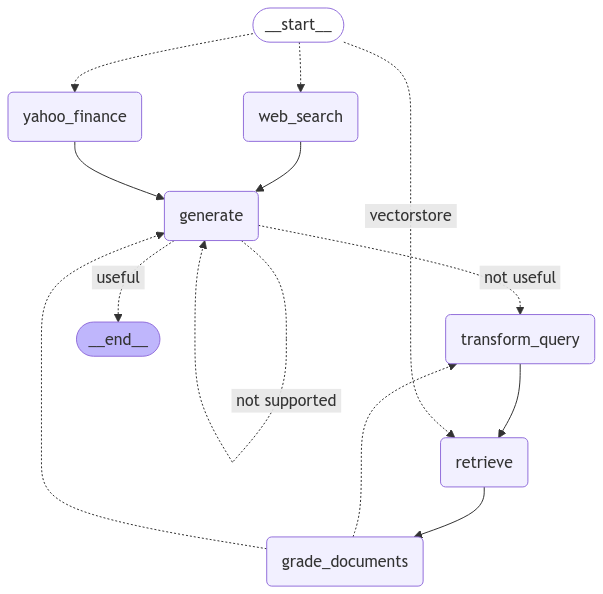

In [9]:
### 6. Run and Visualize the Graph ###
try:
    display(Image(graph_4_adaptiverag.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass


In [11]:
# Interactive Query Loop
while True:
    user_query = input("Enter your query (or type 'exit' to stop): ")
    if user_query.lower() == "exit":
        break
    response = run_adaptive_rag(user_query)
    print("\nResponse:", response, "\n")


Enter your query (or type 'exit' to stop): Stock price of AAPL
Routing 'Stock price of AAPL' to Yahoo Finance
Yahoo Finance Search Results: Latest closing price of AAPL: $233.22

Response: No relevant documents found to generate an answer. 

Enter your query (or type 'exit' to stop): What is machine learning?
Routing 'What is machine learning?' to Vector Store
Vector Store Results: ['VectorStore result 1', 'VectorStore result 2']
Graded Documents: ['VectorStore result 1', 'VectorStore result 2']

Response: Based on the retrieved information:

- VectorStore result 1
- VectorStore result 2 

Enter your query (or type 'exit' to stop): exit
